###  Revisiting the Evolution of Bow-tie Architecture in Signaling Networks: Linear simulation

In [1]:
import sys
import numpy as np
import copy
import matplotlib.pyplot as plt
import random
import math
np.set_printoptions(precision=4, floatmode='maxprec')
np.set_printoptions(suppress=True)
from graphviz import Graph
from graphviz import Digraph
import os 
from scipy.stats import special_ortho_group


class genom:

    genom_list = None
    evaluation = None

    def __init__(self, genom_list, evaluation):
        self.genom_list = genom_list
        self.evaluation = evaluation


    def getGenom(self):
        return self.genom_list


    def getEvaluation(self):
        return self.evaluation


    def setGenom(self, genom_list):
        self.genom_list = genom_list


    def setEvaluation(self, evaluation):
        self.evaluation = evaluation


def WriteNetwork(Ind, nNode, nLayer, count, tidyvisual, correction_v, aling_center):
    #dg = Digraph(format='png')
    dg = Digraph(format='pdf')
    if tidyvisual:
        dg.attr('node', shape='circle', label='')
    else:
        dg.attr('node', shape='circle')
        
    active_node_arr = Active_node_in_MATLAB(Ind, "test")
    #Arrange Nodes
    matrices = Ind.getGenom()
    for layer in range(nLayer):
        for node in range(nNode):
            width = active_node_arr[layer][node]
            name = str(layer)+str(node)
            
            if tidyvisual:
                if width:
                    dg.node(name, penwidth=str(width), style='filled', fillcolor='skyblue')
                elif not aling_center:
                    dg.node(name, penwidth=str(width))
            else:
                dg.node(name, penwidth=str(width))
            
    dg.attr(label="Generation:" + str(count) + "\l" + "fitness:" + str(np.round(Ind.getEvaluation(),4)))
    
    #if count%1000 <= 200:
    #    label_ = "Goal matrix change"
    #else:
    #    label_ = "     "
    label_ = "     "
    
    dg.attr(label="Fitness: " + str(np.round(Ind.getEvaluation(),2)) + 
            "   Generation: " + str(count) + "\n" + label_)
    #dg.node("test", label="Goal matrix change", penwidth=0.1)
    dg.attr(fontsize='16')
    #Write links
    for layer in range(1, nLayer):
        for postnode in range(nNode):
            #row
            post = str(layer) + str(postnode)
            for prenode in range(nNode):
                #column
                pre= str(layer-1) + str(prenode)
                intensity =  matrices[layer-1][postnode, prenode]
                if intensity < 0:
                    color_ = "blue"
                    intensity = abs(intensity)
                else:
                    color_ = "black"
                    
                if tidyvisual:
                    if active_node_arr[layer][postnode] & active_node_arr[layer-1][prenode]:
                        if intensity > correction_v:
                            intensity = correction_v
                        dg.edge(pre, post,  penwidth=str(intensity), arrowsize="0.5", color=color_)
                    elif not aling_center:
                        dg.edge(pre, post,  penwidth='0', arrowsize="0", color=color_)
                else:
                    dg.edge(pre, post,  penwidth=str(intensity), arrowsize="0", color=color_)
    return(dg)



In [2]:

"""
Define functions required for evolutionary simulation
"""

#Create N individuals with nNodes x nLayers
"""
def CreateInd(nNode, nMatrix, From, To):
    #This function returns Node x Node x Layer Matrix, which describe individual's network structure
    Individual =  np.random.uniform(From, To, (nMatrix, nNode, nNode))
    return genom(Individual, 0)

"""
def CreateInd(nNode, nMatrix, norm):
    #This function returns Node x Node x Layer Matrix, which describe individual's network structure
    pre_net =  np.random.uniform(0, 0.05, (nMatrix, nNode, nNode))
    pre_net_norm = (np.linalg.norm(Total_in_out(pre_net), ord="fro")) 
    normalizeF = (norm/pre_net_norm)**(1/(nMatrix))
    network = normalizeF*pre_net
    return genom(network, 0)

def Total_in_out(Ind):
    z = np.dot(Ind[nMatrix -1], Ind[nMatrix -2])
    for i in range(nMatrix -3, -1, -1):
        z = np.dot(z, Ind[i])
    return z

def add_mutation(Ind, corrected_mut_rate, Type):   
    if Type == "Product":
        var = 0.1
        bitmask = np.where(np.random.uniform(0, 1, (nMatrix, nNode, nNode))  < corrected_mut_rate, 1, 0)
        noise_matrix = np.random.normal(1, var, (nMatrix, nNode, nNode))
        pre_mult_mat = bitmask*noise_matrix
        #mult_mat = np.where(pre_mult_mat == 0,  1, pre_mult_mat)
        mult_mat = np.where(pre_mult_mat == 0,  1, pre_mult_mat)
        mutated_network = Ind.getGenom()*mult_mat
        Ind.setGenom(mutated_network)
    elif Type == "NonNegativeAdditive":
        var = 0.1
        bitmask = np.where(np.random.uniform(0, 1, (nMatrix, nNode, nNode))  < corrected_mut_rate, 1, 0)
        noise_matrix = np.random.normal(0, var, (nMatrix, nNode, nNode))  
        add_mat = bitmask*noise_matrix
        mutated_network = Ind.getGenom() + add_mat
        corrected_mutated_network = np.where(mutated_network < 0, 0, mutated_network)
        Ind.setGenom(corrected_mutated_network)
        
    elif Type == "Additive":
        var = 0.1
        bitmask = np.where(np.random.uniform(0, 1, (nMatrix, nNode, nNode))  < corrected_mut_rate, 1, 0)
        noise_matrix = np.random.normal(0, var, (nMatrix, nNode, nNode))  
        add_mat = bitmask*noise_matrix
        mutated_network = Ind.getGenom() + add_mat
        Ind.setGenom(mutated_network)
    return Ind

def select(population, tournament_size):    #Tournament selection
    tournament_groups = [random.sample(population, tournament_size) for i in range(POPULATION_SIZE)]
    selected = [ sorted(tournament_group, reverse=True, key=lambda u: u.evaluation)[0] for tournament_group in tournament_groups]
    return selected


"""
def select(population, tournament_size):
    #エリート選択 25個体
    upper_ind = sorted(population, reverse=True, key=lambda u: u.evaluation)[0:100]
    #非エリートから75個体選択
    #non_upper_ind = [ind for ind in population if ind not in upper_ind]
    #random_ind = random.sample(non_upper_ind, 75)
    return(upper_ind)
"""
"""
def select(population, tournament_size=None):
    #random selection
    random_ind = random.sample(population, 100)
    return  random_ind
"""
def Deleted_fitness(Ind, node, layer):    
    modified_network =  copy.deepcopy(Ind.getGenom())
    Input_link_layer = layer - 1
    Output_link_layer = layer
    if layer == 0: #Eliminate input layer
        modified_network[Output_link_layer][:,node] = 0  #eliminate output
    elif layer == nLayer-1: #Eliminate output layer
        modified_network[Input_link_layer][node,] = 0   #eliminate input
    else: #Eliminate intermidiate layer
        modified_network[Input_link_layer][node,] = 0   #eliminate input from 
        modified_network[Output_link_layer][:,node] = 0
    orig_network = copy.deepcopy(Ind.getGenom())
    
    orig_fit = evaluation(orig_network, DesiredGoal)
    modi_fit = evaluation(modified_network, DesiredGoal)
    relative_fitness = abs(orig_fit-modi_fit)

    return(relative_fitness)


def MaximumInteraction(Ind, node, layer):
    inmax,outmax = 0,0
    if layer > 0:
        inmax = max(Ind.getGenom()[layer-1][node,:])
    if layer < nLayer-1:
        outmax = max(Ind.getGenom()[layer][:,node])
    #threshold: 0.05
    return max(inmax,outmax)


def Relative_fitness_in_layer(layer, mode, Ind, orig_fit):
    relative_fitness = [(Deleted_fitness(Ind, node, layer)) for node in range(nNode)]
    #relative_fitness = [MaximumInteraction(Ind, node, layer) for node in range(nNode)]
    relative_fitness_in_layer = relative_fitness/sum(relative_fitness)
    active_node_test = np.where(relative_fitness_in_layer > 0.001,  1, 0)
    #active_node_test = np.where(relative_fitness_in_layer > 0.05,  1, 0)
    if mode == "result":
        return(sum(active_node_test))
    elif mode == "test":
        return(active_node_test)

def Active_node_in_MATLAB(Ind, mode):
    #orig_fit = abs(evaluation(Ind.getGenom(), DesiredGoal))
    orig_fit = abs(Ind.getEvaluation())
    if orig_fit == 0:
        orig_fit = 0.001
    active_node_list = [Relative_fitness_in_layer(layer, mode, Ind, orig_fit) for layer in range(nLayer)]
    return(active_node_list)

import numpy as np

def CreateRandomGoalMatrix(rank, norm, zvar = np.nan):
    
    if nNode%2 != 0:
        raise ValueError("nNode must be even number")
    

    if rank == 1:
        G = np.full((nNode,nNode),10)
    elif rank == 2:
        a = np.full((int(nNode/2),int(nNode/2)),10)
        b = np.full((int(nNode/2),int(nNode/2)), 0)
        G = np.block([[a,b],[b,a]])
    elif rank == 3:
        a = np.full((int(nNode/3),int(nNode/3)),10)
        b = np.full((int(nNode/3),int(nNode/3)), 0)
        G = np.block([[a,b,b],[b,a,b], [b, b,a]])
    elif rank == 4:
        a = np.full((2,2),10)
        b = np.full((2,2),0)
        c = np.diag([10,10])
        G = np.block([[a,b,b],[b,a,b],[b,b,c]])
        print(G)
    elif rank == 5:
        a = np.full((2,2),10)
        b = np.full((2,2),0)
        c = np.diag([10,10])
        G = np.block([[a,b,b],[b,c,b],[b,b,c]])
     
    elif rank == nNode:
        G = np.diag(np.repeat(10,nNode))
    else:
        raise ValueError("Please choose rank from 1, 2, 3, and 6")

    for i in range(5000):
        #randomize matrix
        rot_m = special_ortho_group.rvs(nNode)
        pre_DesiredGoal = np.dot(rot_m, G)
        print(np.linalg.matrix_rank(pre_DesiredGoal))
        print(pre_DesiredGoal)
        pre_DesiredGoal[pre_DesiredGoal < 0] = -1*pre_DesiredGoal[pre_DesiredGoal < 0]
        print(np.linalg.matrix_rank(pre_DesiredGoal))
        #Uniform frobenius norm
        pre_goal_norm = np.linalg.norm(pre_DesiredGoal, ord="fro")
        DesiredGoal = (norm/pre_goal_norm)*pre_DesiredGoal
        #return np.var(DesiredGoal)
        if not np.isnan(zvar):
            z = (DesiredGoal - np.mean(DesiredGoal))*np.sqrt(zvar)/(np.std(DesiredGoal)) + np.sqrt(100-zvar)
            if len(z[z < 0]) <= 0:
                break
        else:
            z = DesiredGoal
            break
    if len(z[z < 0]) > 0:
        raise ValueError("elements are negative")
    print("found at {}".format(i))
    return(z)


def CreateVirtualDuplicateInd(Ind, DesiredGoal):
    zeros = np.full((nNode,nNode),0.001)
    DuplicateNet = list()
    for LayerInt in Ind.getGenom():
        DuplicateNet.append(np.block([[LayerInt,zeros],[zeros,zeros]]))
    DuplicateNet = np.array(DuplicateNet)
    duplicate_genom = genom(DuplicateNet, evaluation(DuplicateNet, DesiredGoal))
    return duplicate_genom

def Duplicate(network, nNode): 
    DuplicateNet = list()
    for LayerInt in network:
        DuplicateNet.append(np.block([[LayerInt,LayerInt],[LayerInt,LayerInt]]))
    DuplicateNet = np.array(DuplicateNet)
    return DuplicateNet




nNode = 6
rank=1
#mean1 = np.mean([CreateRandomGoalMatrix(1,40,np.nan) for _ in range(1000)] )
#print(mean1)
#mean2 = np.mean([CreateRandomGoalMatrix(2,40,np.nan) for _ in range(1000)] )
#print(mean2)
#mean3 = np.mean([CreateRandomGoalMatrix(3,40,np.nan) for _ in range(1000)] )
#print(mean3)
#mean4 = np.mean([CreateRandomGoalMatrix(6,40,np.nan) for _ in range(1000)] )


In [3]:
#SET RUN TITLE
CreateGif = False
print(os.getcwd())
if CreateGif:
    work_dir = "temp_store_data/"
    try:
        PRJ_TITLE = "expansinoN10_"
        SavePath = work_dir + PRJ_TITLE
        os.chdir("/Users/itoutouma/Research/BowTie")
        os.makedirs(f"{work_dir}{PRJ_TITLE}/result/")
        print(os.getcwd())
    except:
        print("File exist")
    

/Users/itoutouma/Research/BowTie/HPCcode


In [ ]:
from scipy.stats import special_ortho_group
#np.random.seed(42)

def evaluation(Ind_network, DesiredGoal):
    z = Total_in_out(Ind_network)
    fitness = -1*np.sum((z - DesiredGoal)**2) 
    return fitness

def penalty_evaluation(Ind_network, DesiredGoal):
    z = Total_in_out(Ind_network)
    fitness = -1*abs(np.sum((z - DesiredGoal)**2) + 10*np.sum(Ind_network**2))
    return fitness

#evaluation関数はactive node の評価に使われている
#もしpenalty_evaluationを評価に使った場合、大きな相互作用を持つhubの欠失による損失は緩和され影響は相殺される
#penaltyはノードを持つことのコストであり情報処理においてどれくらい大事かには関係ない
#そのためactice node では一貫して normal evaluation関数を使う    


def set_eva(Ind):
    network = Ind.getGenom()
    eva = evaluation(network, DesiredGoal) #Normal
    #eva = penalty_evaluation(network, DesiredGoal)
    Ind.setEvaluation(eva)
    return(Ind)

MutType = "Product"


POPULATION_SIZE = 100
MAX_GENERATION = 500000

nNode = 6
nLayer = 5
NETWORK_NORM = 0.01
GOAL_RANK = 1
GOAL_NORM = 60

DuplicateTime=1000

nMatrix = nLayer-1
MUTATION_RATE = 0.2/(nMatrix*nNode*nNode)

MOTHER_ActiveNodeList = list()
for _ in range(1):

    Initialization = True
    if Initialization:
        variance = np.nan
        DesiredGoal = CreateRandomGoalMatrix(GOAL_RANK, GOAL_NORM, variance)
        #print("Desiredgoal")
        print(DesiredGoal)
        print("size{}".format(np.linalg.norm(DesiredGoal, "fro")))
        current_generation_individual_group_pre = [CreateInd(nNode,nMatrix,NETWORK_NORM) for i in range(POPULATION_SIZE)]
        current_generation_individual_group = [set_eva(Ind) for Ind in  current_generation_individual_group_pre]
        ActiveNodeList = list()
        pre_count = 0
    else:
        #Update their fitness
        DesiredGoal= CreateRandomGoalMatrix(GOAL_RANK, 60)
        current_generation_individual_group = [set_eva(Ind) for Ind in current_generation_individual_group]
        pre_count = count
    
    Clean_Goal = DesiredGoal.copy()
    #Evaluation is initialized. 
    initial_network_size = np.mean([np.linalg.norm(Total_in_out(Ind.getGenom()), 'fro') for Ind in current_generation_individual_group])
    
    print("initial:{}".format(initial_network_size))
    print("Goal matirx rank {}".format(GOAL_RANK))
    #30200
    rank6_noise_waist = list()

    for count in range(pre_count, 160000):  #Repeat generation 
    
        """
        if (count%1000 == 0) & (count > 150000):
            #DesiredGoal=  Clean_Goal + np.random.normal(0, 1, (nNode, nNode)) #
            print("Goal Change")
            change_goal_rank = 6
            DesiredGoal=  CreateRandomGoalMatrix(change_goal_rank, GOAL_NORM, variance)
            current_generation_individual_group = [set_eva(Ind) for Ind in current_generation_individual_group]
        """
        """
        if count == DuplicateTime:
            #Duplicate
            print("Duplicate")
            zeros = np.full((nNode,nNode),0.001)
            DesiredGoal = Duplicate([DesiredGoal], nNode)[0]
            current_generation_individual_group = [
                CreateVirtualDuplicateInd(current_generation_individual_group[i], DesiredGoal) for i in range(POPULATION_SIZE)]
            
            nNode = nNode*2
            mutation_rate = 0.2/(nMatrix*nNode*nNode)
            print("Goal matrix:{}".format(DesiredGoal.shape))
            print("Network:{}\n".format(Total_in_out(current_generation_individual_group[0].getGenom()).shape))
        """
    
        
        next_generation_network = [copy.deepcopy(Ind.getGenom()) for Ind in current_generation_individual_group]
        next_generation_individual_group = [genom(Network, 0) for Network in next_generation_network]
        
        next_generation_individual_group_mutated = [add_mutation(Ind, MUTATION_RATE, MutType) for Ind in next_generation_individual_group]
        next_generation_individual_group_evaluated = [set_eva(Ind) for Ind in  next_generation_individual_group_mutated]
    
        #Selection
        mixed_population = current_generation_individual_group + next_generation_individual_group_evaluated
        #tournament size is 4
        selected_group = select(mixed_population, 4)
    
        #Generation change
        selected_net = [copy.deepcopy(Ind.getGenom()) for Ind in selected_group]
        selected_eva = [Ind.getEvaluation() for Ind in selected_group]
        current_generation_individual_group = [genom(selected_net[i], selected_eva[i]) for i in range(POPULATION_SIZE)]
        
        #most_fitted = sorted(selected_group, reverse=True, key=lambda u: u.evaluation)[0]
        #ConsActiveNode = Active_node_in_MATLAB(most_fitted, mode="result")
        if count%100==0:
            #LossLixt.append(np.mean(selected_eva))
            #Output section for debugging
            most_fitted = sorted(selected_group, reverse=True, key=lambda u: u.evaluation)[0]
            #print("average interaction:{}".format(np.mean(most_fitted.getGenom())))
            ConsActiveNode = Active_node_in_MATLAB(most_fitted, mode="result")
            ConsActiveNode.append(np.mean(selected_eva))
            ActiveNodeList.append(ConsActiveNode)
            #print("-----第{}世代の結果-----".format(count))
            #print("Min:{}".format(min(selected_eva)))
            #print("Max:{}".format(max(selected_eva)))
            #print("Avg:{}".format(np.mean(selected_eva)))
            print("Gen{}, Loss:{}, Active node:\n{}".format(count, np.mean(selected_eva), ConsActiveNode))
            #print("Feobenius norm: {}\n".format(np.linalg.norm(Total_in_out(most_fitted.getGenom()), 'fro')))
            #rank6_noise_waist.append(ConsActiveNode)
            if CreateGif:
                #G = WriteNetwork_effect_on_layer(most_fitted, nNode, nLayer, count, False)
                tidyvisual = True
                correction_v=15
                #correction_v=2 #if it's 3 node
                G = WriteNetwork(most_fitted, nNode, nLayer, count, tidyvisual, correction_v, False)
                #T = SimpleWriteNetwork(Total_in_out(most_fitted.getGenom()), nNode, 2, count)
                Gtitle = SavePath +"/"+  str((count)) + "Gen"
                #Ttitle = SavePath + "/" + str(count) + "Tot"
                G.render(Gtitle)
                #T.render(Ttitle)
        """    
        if abs(np.mean(selected_eva)) < 0.01:
        #if abs(np.mean(selected_eva)) > 10000:
            most_fitted = sorted(selected_group, reverse=True, key=lambda u: u.evaluation)[0]
            ActiveNode = Active_node_in_MATLAB(most_fitted, mode="result")
            #Waist = np.min(ActiveNode)
            print("Min:{}".format(min(selected_eva)))
            print("Max:{}".format(max(selected_eva)))
            print("Avg:{}".format(np.mean(selected_eva)))
            print("Active node:{}".format(ActiveNode))
            print("Quit GA:{}".format(count))
            break
        """
    MOTHER_ActiveNodeList.append(ActiveNodeList)

print("End")

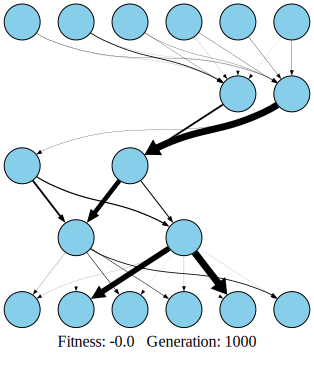

In [12]:
G = WriteNetwork(most_fitted, nNode, nLayer, 1000, True, 10, False)
G

In [ ]:
import shutil
SavePath = ".BowTieEvo/temp_store_data/PRJ_TITLE"
filelist = os.listdir(SavePath)
print(SavePath)
mvfiles = [s for s in filelist if "Gen.png" in s]
mvfilespath = [SavePath + "/"  + s for s in mvfiles]
for file in mvfilespath:
    shutil.move(file, SavePath + '/result')

In [ ]:
 from PIL import Image
import glob
import re
import os
 
def create_gif(in_dir, out_filename):
    print(*[in_dir, '*'])
    path_list = glob.glob(os.path.join(*[in_dir, '*']))
    sort_path_list = sorted(path_list , key=lambda x:int((re.search(r"[0-9]+", x)).group(0)))
    print(sort_path_list)
    imgs = []                                                   # 画像をappendするための空配列を定義
 
    # ファイルのフルパスからファイル名と拡張子を抽出
    for i in range(len(sort_path_list)):
        img = Image.open(sort_path_list[i])                          # 画像ファイルを1つずつ開く
        imgs.append(img)                                        # 画像をappendで配列に格納していく
    imgs[0].save(out_filename, save_all=True, append_images=imgs[1:], optimize=False, duration=200, loop=1)

SavePath = "temp_store_data/"
os.chdir(SavePath)
create_gif(in_dir="./result", out_filename=SavePath + '/MostFitEvo3.gif')